# Report

This notebook is used for generating figures for the report of the project.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ddro import pg, solvers, benchmark
import os

FIGURE_DIR = os.path.join("..", "doc", "figure")

In [26]:
# Reproducibility
np.random.seed(1234)

# Limits of the space
x_lim = (-10, 10)
y_lim = (-10, 10)
num_fac = 10
num_cs = 20
fac_pos = np.stack(
    (
        np.random.uniform(x_lim[0], x_lim[1], num_fac),
        np.random.uniform(y_lim[0], y_lim[1], num_fac),
    ),
    axis=1,
)
cs_pos = np.stack(
    (
        np.random.uniform(x_lim[0], x_lim[1], num_cs),
        np.random.uniform(y_lim[0], y_lim[1], num_cs),
    ),
    axis=1,
)
dd_sup = np.arange(1, 101)  # Demand support
cs_oc = np.random.uniform(5000, 10000, size=num_fac)
fac_cap = cs_oc / 200  # Facility capacities
cs_rev = np.random.uniform(140, 160, num_cs)  # Costumer site revenues
cs_pen = np.repeat(250, num_cs)  # Costumer site penalties
t_factor = np.random.uniform(
    2, 3, size=(num_fac, num_cs)
)  # Transportation factor
dist = lambda x, y: np.linalg.norm(x - y)  # L2 distance
## Compute the distances between facilities and costumer sites
## and compute the transportation costs
t_costs = np.empty_like(t_factor)
for i in range(num_fac):
    for j in range(num_cs):
        t_costs[i, j] = t_factor[i, j] * dist(fac_pos[i], cs_pos[j])

flp = pg.FLP(
    nf=num_fac,
    nc=num_cs,
    sd=dd_sup,
    oc=cs_oc,
    tc=t_costs,
    cf=fac_cap,
    rc=cs_rev,
    pc=cs_pen,
)

Solve the FLP by each solver.

In [27]:
bas_solver = solvers.BASSolver(nf=flp.nf, nc=flp.nc)
dr_solver = solvers.DRSolver(nf=flp.nf, nc=flp.nc)
p_solver = solvers.PSolver()

In [28]:
assert bas_solver.solve(flp)
assert dr_solver.solve(flp)
assert p_solver.solve(flp)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 65540 rows, 5030 columns and 296220 nonzeros
Model fingerprint: 0xd50c2aa6
Variable types: 5020 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [8e-01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+05]
Presolve removed 38563 rows and 2261 columns
Presolve time: 0.72s
Presolved: 26977 rows, 2769 columns, 233207 nonzeros
Variable types: 2759 continuous, 10 integer (10 binary)
Found heuristic solution: objective -107190.9880
Root relaxation presolved: 26977 rows, 2769 columns, 233207 nonzeros


Root relaxation: objective -2.981697e+09, 4041 iterations, 1.23 secon

In [29]:
ys = [bas_solver.y, dr_solver.y, p_solver.y]
N = 250

In [34]:
print(ys)

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([-0.,  1., -0., -0., -0., -0., -0., -0., -0., -0.]), array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])]


## Situation 1

In [30]:
prob = np.random.uniform(size=(flp.nc, len(flp.sd)))
prob = prob / prob.sum(1)[:, np.newaxis]

objs, ss = benchmark.benchmark(ys, flp, prob, N)

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 110000 rows, 55000 columns and 160000 nonzeros
Model fingerprint: 0x2a391e31
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 106831 rows and 22459 columns
Presolve time: 0.08s
Presolved: 3169 rows, 32541 columns, 32541 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 9.850e+02 (roughly 4 MB of memory)
 Factor Ops : 9.850e+02 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.11 seconds (0.08 work units)
Barrier solve interrupted - model solved

In [31]:
for i, label in enumerate(["DDDRO Model", "DRO Model", "Deterministic Model"]):
    print(label)
    print(f"Objective = {objs[:, i].mean()} +- {objs[:, i].std(ddof=1)}, CI(95%) = ({objs[:, i].mean() - 1.96 * objs[:, i].std() / np.sqrt(N)}, {objs[:, i].mean() + 1.96 * objs[:, i].std() / np.sqrt(N)})")
    print(f"Unsatisfied demand = {ss[:, i].mean()} +- {ss[:, i].std(ddof=1)}, CI(95%) = ({ss[:, i].mean() - 1.96 * ss[:, i].std() / np.sqrt(N)}, {ss[:, i].mean() + 1.96 * ss[:, i].std() / np.sqrt(N)})")
    print("=====================================================================")

DDDRO Model
Objective = -73716.51833098695 +- 18383.691194829742, CI(95%) = (-75990.8220024684, -71442.2146595055)
Unsatisfied demand = 0.0 +- 0.0, CI(95%) = (0.0, 0.0)
DRO Model
Objective = -43277.10269899434 +- 7269.839525526682, CI(95%) = (-44176.47717981876, -42377.72821816993)
Unsatisfied demand = 359.4807965985948 +- 92.05914616687737, CI(95%) = (348.09187301943564, 370.86972017775395)
Deterministic Model
Objective = 101462.262481392 +- 13203.060928416433, CI(95%) = (99828.87070897494, 103095.65425380906)
Unsatisfied demand = 1019.068 +- 132.89606779488008, CI(95%) = (1002.6270137090451, 1035.508986290955)


(array([ 5., 16., 28., 48., 53., 51., 25., 14.,  4.,  6.]),
 array([ 69135.77522143,  76261.83504369,  83387.89486595,  90513.95468821,
         97640.01451047, 104766.07433273, 111892.13415499, 119018.19397725,
        126144.25379951, 133270.31362177, 140396.37344403]),
 <BarContainer object of 10 artists>)

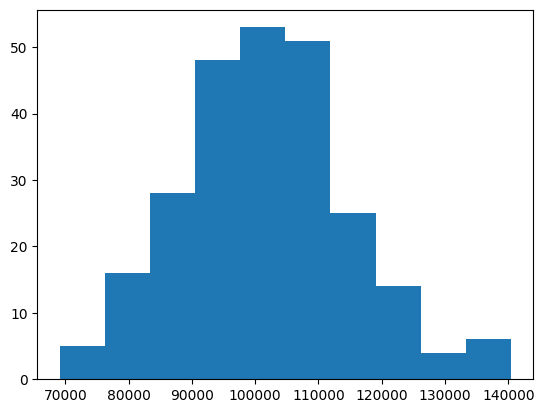

In [32]:
plt.hist(objs[:, 2])

/tmp/ipykernel_30748/582260494.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


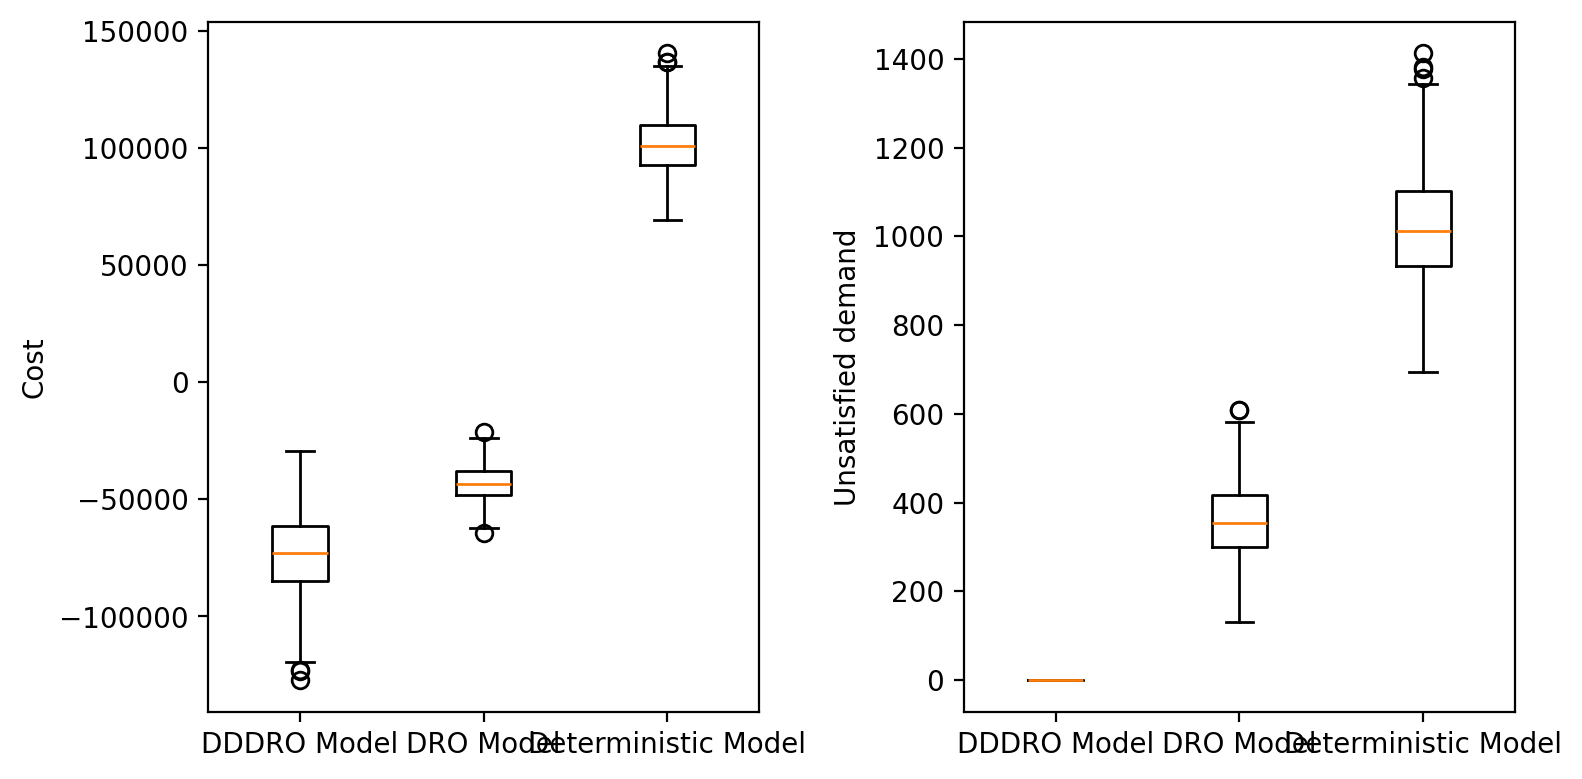

In [33]:
fig = plt.figure(dpi=200, figsize=(8, 4))
axl = fig.add_subplot(1, 2, 1)
axr = fig.add_subplot(1, 2, 2)
labels = ["DDDRO Model", "DRO Model", "Deterministic Model"]
axl.boxplot(
    x=objs,
    tick_labels=labels,
)
axl.set_ylabel("Cost")
axr.boxplot(x=ss, tick_labels=labels)
axr.set_ylabel("Unsatisfied demand")
fig.tight_layout()
fig.savefig(os.path.join(FIGURE_DIR, "situation1_benchmark.png"))
fig.show()

## Situation 2